---
**Turma:** 15

**Grupo:** 11 - Bruno Correia, Gilson Costa, Vivian Liu

**Contato**: `brunovpm@hotmail.com, gilson.costa@gmail.com, liuoliveira.vivian@gmail.com`

**Licença deste notebook**:
![CC BY](https://licensebuttons.net/l/by/3.0/88x31.png)

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)

---
# Árvore Decisão

In [0]:
root_dir = '/dbfs/FileStore/ifood'

dbutils.fs.ls(f'{root_dir}')

Out[1]: [FileInfo(path='dbfs:/dbfs/FileStore/ifood/abt/', name='abt/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/customer_segmentation/', name='customer_segmentation/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/enrich/', name='enrich/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/marketing_push_full/', name='marketing_push_full/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/orders/', name='orders/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/orders_with_cost_revenue/', name='orders_with_cost_revenue/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/preprocess/', name='preprocess/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/sessions_visits/', name='sessions_visits/', size=0)]

### Load ABT Train Test

In [0]:
abt = 'abt_case_aug_half_end'

df_abt_case_train = spark.read.parquet(
  f'{root_dir}/abt/{abt}_train'
).repartition(2).cache()
df_abt_case_train.createOrReplaceTempView(f'{abt}_train')
df_abt_case_train.createOrReplaceTempView('abt_train')

df_abt_case_test = spark.read.parquet(
  f'{root_dir}/abt/{abt}_test'
).repartition(2).cache()
df_abt_case_test.createOrReplaceTempView(f'{abt}_test')
df_abt_case_test.createOrReplaceTempView('abt_test')

df_abt_case_train.count(), df_abt_case_test.count()

Out[2]: (21036, 9043)

### VectorAssembler

In [0]:
from pyspark.ml.feature import VectorAssembler

featureList = [c for c in df_abt_case_train.columns if c not in ['label', 'customer_id']]

assembler = VectorAssembler(inputCols=featureList, outputCol = 'features')

dfAssemblerTrain = assembler.transform(df_abt_case_train)
dfAssemblerTest  = assembler.transform(df_abt_case_test)

# Pipeline

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

decisionTree = DecisionTreeClassifier(
  featuresCol='features',
  labelCol='label',
  maxDepth=5,
  impurity='gini'
)

pipeline = Pipeline(stages=[decisionTree])

#### Training

In [0]:
model = pipeline.fit(dfAssemblerTrain)

### Evaluation on Test

In [0]:
dfPrediction = model.transform(dfAssemblerTest)

#### Metric ROC PR

In [0]:
import pandas as pd

evaluator = BinaryClassificationEvaluator()

pdPrection = pd.DataFrame({
  "areaUnderROC": [evaluator.setMetricName("areaUnderROC").evaluate(dfPrediction)],
  "areaUnderPR": [evaluator.setMetricName("areaUnderPR").evaluate(dfPrediction)]
})

pdPrection.transpose()

,0
areaUnderROC,0.931638
areaUnderPR,0.866879


#### Confussion Matrix

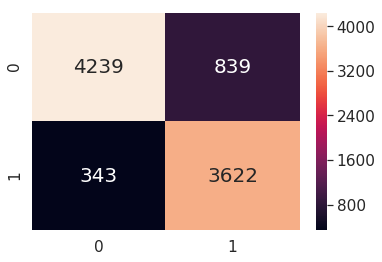

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pdCvMatrix = dfPrediction.select('label', 'prediction').toPandas()

cm = confusion_matrix(pdCvMatrix['label'], pdCvMatrix['prediction'])

sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, fmt='g')

#### Classification Report

In [0]:
from sklearn.metrics import classification_report 
import pandas as pd
pd.set_option('display.precision', 6)

dfReport = dfPrediction.select('label', 'prediction').toPandas()

dict = classification_report(dfReport['label'], dfReport['prediction'], output_dict=True)
pd.DataFrame(dict)

,0,1,micro avg,macro avg,weighted avg
f1-score,0.877640,0.859720,0.869291,0.868680,0.869783
precision,0.925142,0.811926,0.869291,0.868534,0.875501
recall,0.834777,0.913493,0.869291,0.874135,0.869291
support,5078.000000,3965.000000,9043.000000,9043.000000,9043.000000


In [0]:
import pandas as pd

pdImportance = pd.DataFrame(finalModel.featureImportances.toArray()).transpose()
pdImportance.columns = featureList
pdImportance.transpose().sort_values(by=0, ascending=False)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3182795730476218> in <module> 
 1 import pandas as pd
 2 
 ----> 3 pdImportance = pd . DataFrame ( finalModel . featureImportances . toArray ( ) ) . transpose ( ) 
 4 pdImportance . columns = featureList
 5 pdImportance . transpose ( ) . sort_values ( by = 0 , ascending = False ) 

 NameError : name 'finalModel' is not defined

### Visualizando a árvore gerada

Imagem gerada com o o código abaixo
<img src="files/arvore_decisao.png">

In [0]:
finalModel = model.stages[-1]

display(finalModel)

treeNode
"{""index"":11,""featureType"":""continuous"",""prediction"":null,""threshold"":0.5,""categories"":null,""feature"":19,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":0.5,""categories"":null,""feature"":26,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":10.5,""categories"":null,""feature"":1,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":25.5,""categories"":null,""feature"":1,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":0.37096774,""categories"":null,""feature"":4,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":0.532258065,""categories"":null,""feature"":4,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"


In [0]:
from spark_tree_plotting import export_graphviz

# 0 nao_tera_doenca_coracao
# 1 tera_doenca_coracao
dot_data = export_graphviz(
  finalModel,
  featureNames=featureList,
  classNames=['No_Churn', 'Churn'],
  filled=True,
  roundedCorners=True,
  roundLeaves=True
)

In [0]:
%sh
pip install pydotplus
sudo apt-get install -y graphviz

Collecting pydotplus
 Downloading https://files.pythonhosted.org/packages/60/bf/62567830b700d9f6930e9ab6831d6ba256f7b0b730acb37278b0ccdffacf/pydotplus-2.0.2.tar.gz (278kB)
Requirement already satisfied: pyparsing>=2.0.1 in /databricks/python3/lib/python3.7/site-packages (from pydotplus) (2.4.6)
Building wheels for collected packages: pydotplus
 Building wheel for pydotplus (setup.py): started
 Building wheel for pydotplus (setup.py): finished with status 'done'
 Stored in directory: /root/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus
Installing collected packages: pydotplus
Successfully installed pydotplus-2.0.2
You are using pip version 19.0.3, however version 20.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
 libgnutls-openssl27
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
 fonts-liberation libcdt5 libcgraph6 libgvc6 libgvpr2 libpathplan4
Suggested packages:
 graphviz-doc
The following NEW packages will be installed:
 fonts-liberation graphviz libcdt5 libcgraph6 libgvc6 libgvpr2 libpathplan4
0 upgraded, 7 newly installed, 0 to remove and 0 not upgraded.
Need to get 2,364 kB of archives.
After this operation, 14.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu xenial/main amd64 fonts-liberation all 1.07.4-1 [829 kB]
Get:2 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libcdt5 amd64 2.38.0-12ubuntu2.1 [23.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libcgraph6 amd64 2.38.0-12ubuntu2.1 [43.6 kB]
Get:4 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libpathplan4 amd64 2.38.0-12ubuntu2.1 [26.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libgvc6 amd64 2.38.0-12ubuntu2.1 [591 kB]
Get:6 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libgvpr2 amd64 2.38.0-12ubuntu2.1 [170 kB]
Get:7 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 graphviz amd64 2.38.0-12ubuntu2.1 [680 kB]
debconf: delaying package configuration, since apt-utils is not installed
Fetched 2,364 kB in 1s (1,545 kB/s)
Selecting previously unselected package fonts-liberation.
(Reading database ... 
(Reading database ... 5%
(Reading database ... 10%
(Reading database ... 15%
(Reading database ... 20%
(Reading database ... 25%
(Reading database ... 30%
(Reading database ... 35%
(Reading database ... 40%
(Reading database ... 45%
(Reading database ... 50%
(Reading database ... 55%
(Reading database ... 60%
(Reading database ... 65%
(Reading database ... 70%
(Reading database ... 75%
(Reading database ... 80%
(Reading database ... 85%
(Reading database ... 90%
(Reading database ... 95%
(Reading database ... 100%
(Reading database ... 61890 files and directories currently installed.)
Preparing to unpack .../fonts-liberation_1.07.4-1_all.deb ...
Unpacking fonts-liberation (1.07.4-1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../libcdt5_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking libcdt5 (2.38.0-12ubuntu2.1) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../libcgraph6_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking libcgraph6 (2.38.0-12ubuntu2.1) ...
Selecting previously unselected package libpathplan4.
Preparing to unpack .../libpathplan4_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking libpathplan4 (2.38.0-12ubuntu2.1) ...
Selecting previously unselected package libgvc6.
Preparing to unpack .../libgvc6_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking libgvc6 (2.38.0-12ubuntu2.1) ...
Selecting previously unselected package libgvpr2.
Preparing to unpack .../libgvpr2_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking libgvpr2 (2.38.0-12ubuntu2.1) ...
Selecting previously unselected package graphviz.
Preparing to 

In [0]:
import pydotplus

# Converte o modelo de arvore gerado para imagem
imagem = pydotplus.graph_from_dot_data(dot_data)

# Para visualizar será necessário armazenar a imagem no DBFS
imagem.write_png('/dbfs/FileStore/arvore_decisao.png')

Out[16]: True

Para visualizar o código que carrega a imagem, clique duas vezes nessa cédula.
<img src="files/arvore_decisao.png">

In [0]:
import pandas as pd

pd.DataFrame(
  {'feature': featureList, 'importance': finalModel.featureImportances.toArray()}
).sort_values('importance', ascending=False)

,feature,importance
19,sum_event_open,0.900379
26,label_last_month,0.067772
1,qtt_orders_last_year,0.027687
4,recency_months,0.004163
15,total_send,0.000000
25,order_session_quantity,0.000000
24,sum_callback_purchase,0.000000
23,sum_view_checkout,0.000000
22,sum_click_add_item,0.000000
21,sum_view_dish_screen,0.000000
